# Import Libs

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Preparation (Setting the Random State)

In [2]:
rs = min(289456, 274211)
np.random.seed(rs)

# Exercise 1 (Loading and Preparing the Data)
craeting sub_DF `workdf` and removing some random columns and updating

In [3]:
# 1.1 Load the CSV file into a pandas DataFrame
df_tot = pd.read_csv('cla4lsp_customers.csv', sep='\t')

# 1.2 Create a sub-DF workdf with 2/3 of the original dataframe's rows (randomly sampled)
workdf = df_tot.sample(frac=2 / 3, random_state=rs)

# 1.3 hard-code labels and feature
labels = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
          'AcceptedCmp5', 'Response', 'Complain', 'Recency']
features = ['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
columns_to_remove = ['ID', 'Z_CostContact', 'Z_Revenue']
# 1.4 Remove one feature column randomly from spending or purchasing habits
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                    'NumCatalogPurchases', 'NumStorePurchases']
col_to_remove = np.random.choice(spending_columns)
columns_to_remove.append(col_to_remove)
print("Random Column to be dropped: ", col_to_remove)
features.remove(col_to_remove)
workdf.drop(columns_to_remove, axis=1, inplace=True)
workdf.info()

Random Column to be dropped:  MntSweetProducts
<class 'pandas.core.frame.DataFrame'>
Index: 1493 entries, 335 to 1224
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           1493 non-null   int64  
 1   Education            1493 non-null   object 
 2   Marital_Status       1493 non-null   object 
 3   Income               1476 non-null   float64
 4   Kidhome              1493 non-null   int64  
 5   Teenhome             1493 non-null   int64  
 6   Dt_Customer          1493 non-null   object 
 7   Recency              1493 non-null   int64  
 8   MntWines             1493 non-null   int64  
 9   MntFruits            1493 non-null   int64  
 10  MntMeatProducts      1493 non-null   int64  
 11  MntFishProducts      1493 non-null   int64  
 12  MntGoldProds         1493 non-null   int64  
 13  NumDealsPurchases    1493 non-null   int64  
 14  NumWebPurchases      1493 non-null   int64  

    Since we have missing values in the income column we drop the missing values

In [4]:
# 1.5 Clean the dataset from missing values in the feature columns
workdf.dropna(inplace=True)
workdf.isnull().sum()


Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

# Exercise 2 (Encoding of Categorical Data)

In [5]:
categorical_columns = list(workdf.select_dtypes(include=['object']).columns)
print("The categorical columns: ",categorical_columns)

The categorical columns:  ['Education', 'Marital_Status', 'Dt_Customer']


In [6]:
for col in categorical_columns:
    unique_values = workdf[col].unique()
    print(f"Number of Unique values in '{col}': {len(unique_values)}")
    if len(unique_values) < 20:
        print(unique_values)


Number of Unique values in 'Education': 5
['Graduation' 'Master' 'PhD' '2n Cycle' 'Basic']
Number of Unique values in 'Marital_Status': 8
['Divorced' 'Together' 'Married' 'Single' 'Widow' 'Alone' 'YOLO' 'Absurd']
Number of Unique values in 'Dt_Customer': 609


1. Education:
   - Suggested Encoding Method: Ordinal Encoding or One-Hot Encoding
   - Reasoning: Since there is an inherent order in the education levels (e.g., "High School" < "Bachelor" < "Master"), we consider using Ordinal Encoding.

3. Marital_Status:
   - Suggested Encoding Method: One-Hot Encoding
   - Reasoning: Marital status typically doesn't have a natural order, making One-Hot Encoding a suitable choice.

3. Dt_Customer:
   - Suggested Encoding Method: Ordinal Encoding (if there's an order) or Feature Engineering
   - Reasoning: Since this column represents dates, encoding methods are a bit different compared to traditional categorical variables. Instead of directly encoding the date, we'll extract useful features from it. Common features to extract include the year, month, day, and potentially others like day of the week.

## Encoding for Dt_Customer:

In [7]:
Xworkdf = workdf[features].copy()
Xworkdf['Dt_Customer'] = pd.to_datetime(Xworkdf['Dt_Customer'], format="%d-%m-%Y")
Xworkdf['Dt_Customer_Year'] = Xworkdf['Dt_Customer'].dt.year
Xworkdf['Dt_Customer_Month'] = Xworkdf['Dt_Customer'].dt.month
Xworkdf['Dt_Customer_Day'] = Xworkdf['Dt_Customer'].dt.day
Xworkdf['Dt_Customer_DayOfWeek'] = Xworkdf['Dt_Customer'].dt.dayofweek

# now that we're done we can drop Dt_Customer
Xworkdf.drop("Dt_Customer", axis=1, inplace=True)
Xworkdf.columns

Index(['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome',
       'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntGoldProds', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Dt_Customer_Year', 'Dt_Customer_Month', 'Dt_Customer_Day',
       'Dt_Customer_DayOfWeek'],
      dtype='object')

## Encoding for Marital_Status:

In [8]:
Xworkdf = pd.get_dummies(Xworkdf, columns=['Marital_Status'])

## Encoding for Education:

In [9]:
#encode the education column as ordinal
education_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
Xworkdf['Education'] = Xworkdf['Education'].map(education_map)
features = Xworkdf.columns

Xworkdf.columns

Index(['Education', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Dt_Customer_Year', 'Dt_Customer_Month',
       'Dt_Customer_Day', 'Dt_Customer_DayOfWeek', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')

In [10]:
Xworkdf.describe()

,Education,Year_Birth,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Dt_Customer_Year,Dt_Customer_Month,Dt_Customer_Day,Dt_Customer_DayOfWeek
count,1476.000000,1476.000000,1476.000000,1476.000000,1476.00000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000
mean,2.443089,1968.714092,52365.170054,0.441057,0.51355,297.000678,26.665989,164.907182,36.900407,42.713415,4.086721,2.631436,5.819783,5.325881,2013.020325,6.422087,15.889566,3.027100
std,0.986767,11.571659,26827.404417,0.537333,0.54910,334.039958,39.995053,225.822463,54.157375,49.755768,2.781647,2.984196,3.255666,2.380180,0.686623,3.488872,8.880182,2.015014
min,0.000000,1943.000000,1730.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,1.000000,0.000000
25%,2.000000,1959.000000,35434.750000,0.000000,0.00000,23.000000,2.000000,16.000000,3.000000,9.000000,2.000000,0.000000,3.000000,4.000000,2013.000000,3.000000,8.000000,1.000000
50%,2.000000,1970.000000,51153.000000,0.000000,0.00000,168.000000,8.000000,67.000000,12.000000,24.000000,3.000000,2.000000,5.000000,6.000000,2013.000000,6.000000,16.000000,3.000000
75%,3.000000,1977.000000,68336.250000,1.000000,1.00000,483.000000,33.000000,223.250000,48.000000,56.250000,6.000000,4.000000,8.000000,7.000000,2013.000000,9.000000,23.000000,5.000000
max,4.000000,1996.000000,666666.000000,2.000000,2.00000,1492.000000,199.000000,1725.000000,259.000000,321.000000,27.000000,28.000000,13.000000,20.000000,2014.000000,12.000000,31.000000,6.000000


Based on the table above what we can notice is that for column **Income** we have outliers. Beacuse $75%$ of the income is around $68336$ and the max value is around $666666$.
As an experiment we tried to remove all outliers from the `Xworkdf` but the decrease in number of rows was really high. So we only try to remove outliers from **Income** because the gap is really high.

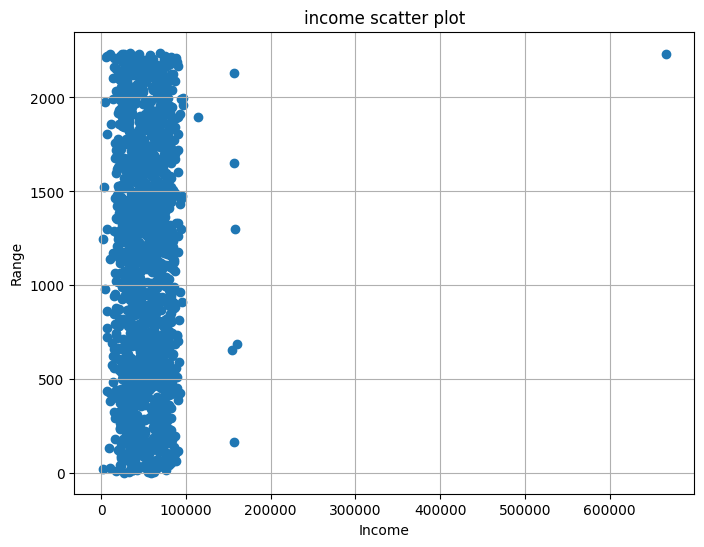

In [11]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Xworkdf['Income'],Xworkdf.index)
    
plt.xlabel('Income')
plt.ylabel('Range')
plt.title('income scatter plot')
plt.grid()
plt.show()

In [12]:
Xworkdf = Xworkdf[Xworkdf['Income'] <= 100000]
workdf = workdf[workdf['Income'] <= 100000]

# Exercise 3 (Preprocessing and full-PCA)

## Create two DFs Xworkdf std and Xworksf mmf

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# create a DataFrame with the standardized features
Xworkdf_std = pd.DataFrame(std_scaler.fit_transform(Xworkdf))
Xworkdf_mm = pd.DataFrame(minmax_scaler.fit_transform(Xworkdf))

# Assign column names to the standardized DataFrame
Xworkdf_std.columns = Xworkdf.columns

# Assign column names to the min-max scaled DataFrame
Xworkdf_mm.columns = Xworkdf.columns

## Comparison of the Variances

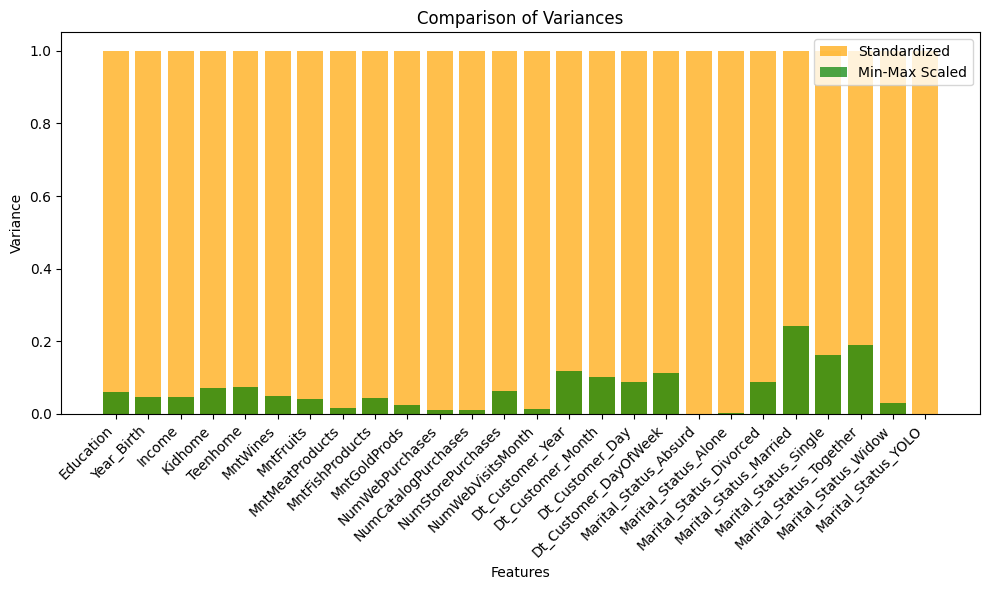

In [14]:

# Calculate variances for each DataFrame
variances_original = Xworkdf.var()
variances_std = Xworkdf_std.var()
variances_mm = Xworkdf_mm.var()

# Plot the variances
plt.figure(figsize=(10, 6))
plt.bar(variances_std.index, variances_std, color='orange', alpha=0.7, label='Standardized')
plt.bar(variances_mm.index, variances_mm, color='green', alpha=0.7, label='Min-Max Scaled')

plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Comparison of Variances')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [15]:
variance_comparison = pd.DataFrame({
    'Original': variances_original,
    'StandardScaler': variances_std,
    'MinMaxScaler': variances_mm
})

# Display the comparison
display(variance_comparison)


,Original,StandardScaler,MinMaxScaler
Education,9.717820e-01,1.000682,0.060736
Year_Birth,1.337283e+02,1.000682,0.047607
Income,4.179913e+08,1.000682,0.046205
Kidhome,2.890786e-01,1.000682,0.072270
Teenhome,3.017312e-01,1.000682,0.075433
MntWines,1.117582e+05,1.000682,0.050204
MntFruits,1.605465e+03,1.000682,0.040541
MntMeatProducts,4.670694e+04,1.000682,0.015697
MntFishProducts,2.942970e+03,1.000682,0.043872
MntGoldProds,2.480786e+03,1.000682,0.024076


### Analyzing the Variance of across dataframes
01. **Original Data**:
The variances in the "Original" column represent the original distribution of the data before any scaling.
Variances vary significantly across columns, as the scale of the features is different.

2. **MinMaxScaler** (scaling values to a specific range, e.g., $[0, 1]$):
The variance is generally affected. Min-Max Scaling squeezes the data within a fixed interval(in this case $[0,1]$), so the range of values will be smaller, impacting the spread of the data.

3. **Standardscaler** (Z-score Normalization):
Standardscaler centers the data around a mean of $0$ and scales it by the standard deviation. This process does not change the variance, as it maintains the spread of the data relative to its mean.

## Apply the “full” PCA

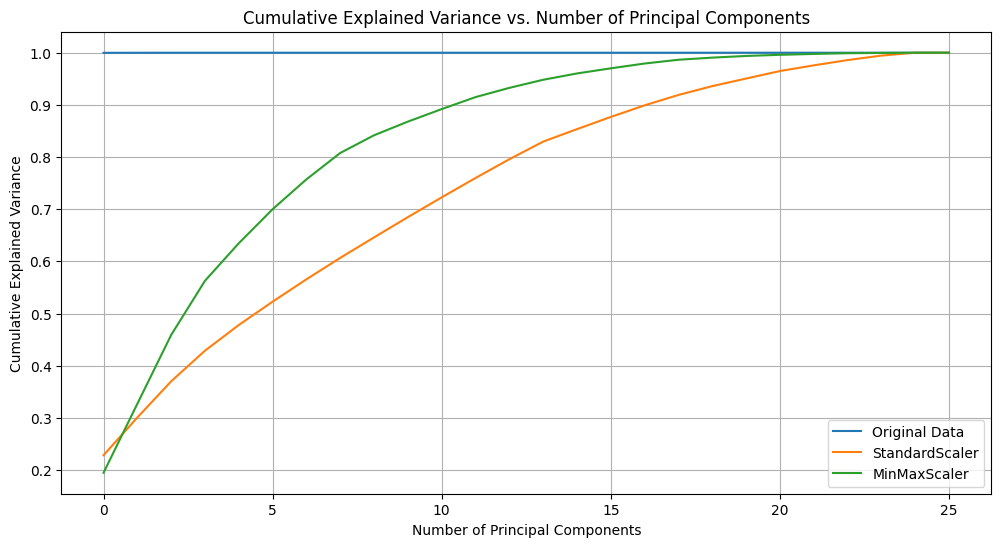

In [16]:
from sklearn.decomposition import PCA

# Initialize PCA for each dataframe
pca_original = PCA()
pca_std = PCA()
pca_mm = PCA()

# Fit and transform the data
_ = pca_original.fit_transform(Xworkdf)
_ = pca_std.fit_transform(Xworkdf_std)
_ = pca_mm.fit_transform(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_explained_variance_original = np.cumsum(pca_original.explained_variance_ratio_)
cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_explained_variance_original, label='Original Data')
plt.plot(cumulative_explained_variance_std, label='StandardScaler')
plt.plot(cumulative_explained_variance_mm, label='MinMaxScaler')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.show()



1. **Blue Line - Original Data:**
   - The values are extremely close to 1, starting from the very first PC, indicating that almost all the variance in the data is explained by the first principal component.
   - This might suggest that the data has one dominant feature that captures nearly all the information, which could happen if the data points are aligned along one major axis or if there is a strong linear relationship among the features.
   - Since the values are already so close to 1 from the beginning, additional components do not contribute significantly to explaining more variance. The dataset could be effectively reduced to one dimension without losing information.
   - The fact that this line is above the others for any given number of components indicates that the principal components of the original data explain more variance than the principal components of the scaled data.

2. **Green Line - MinMaxScaler:**
   - These values start at approximately 0.20 and gradually increase to 1, indicating that the variance is spread across several components.
   - The more gradual slope suggests that the scaling has distributed the variance such that no single component dominates the explanation of variance. This is more typical of PCA results where multiple components are needed to adequately capture the structure of the data.
   - The cumulative variance reaches 1 at the 25th component, meaning that all components are needed to capture the entire variance of the dataset, which implies that MinMax scaling has preserved the multi-dimensional structure of the data.

3. **Orange Line - StandardScaler:**
   - The cumulative variance for the StandardScaler starts at around 0.22 and similarly increases to 1 by the 25th component.
   - The shape of the curve suggests that while the first component explains a significant portion of the variance, it is less dominant compared to the original data.
   - The need for more components to reach a cumulative variance of 1 indicates that StandardScaler, like MinMaxScaler, has distributed the variance across multiple dimensions of the data.

In summary:

- The original data seems to be characterized by a single, very strong component, which could be due to highly correlated features or a single dominant feature.
- The MinMaxScaler and StandardScaler have normalized the data in such a way that the variance is more evenly spread across the components. This implies that the underlying dimensionality of the scaled data is higher than that of the original data.
- The PCA on scaled data does not show a single dominant feature, as opposed to the original data, which could be beneficial for machine learning applications where we want to avoid features with disproportionate influence on the model.
- For the MinMaxScaler and StandardScaler data, more principal components are required to capture the same amount of information as the original data, which indicates that scaling has the effect of "spreading out" the information across multiple dimensions.

# Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

Number of PCs for StandardScaler: 3
Number of PCs for MinMaxScaler: 3


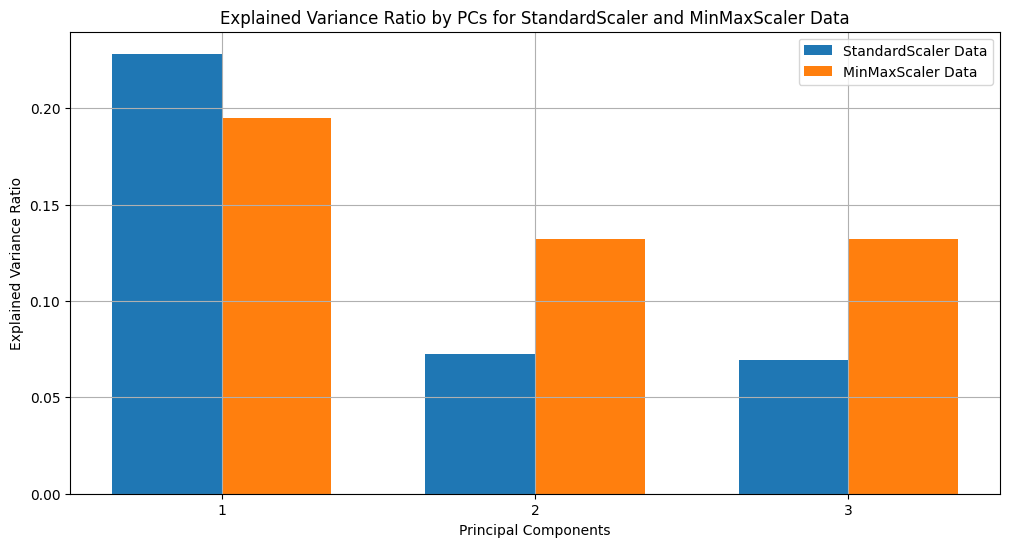

In [17]:
variance_threshold = 0.33

# Determine the number of principal components for StandardScaler data
num_pcs_std = np.argmax(cumulative_explained_variance_std >= variance_threshold) + 1
m_std = min(num_pcs_std, 5)
print(f"Number of PCs for StandardScaler: {m_std}")

# Determine the number of principal components for MinMaxScaler data
num_pcs_mm = np.argmax(cumulative_explained_variance_mm >= variance_threshold) + 1
m_mm = min(num_pcs_mm, 5)
print(f"Number of PCs for MinMaxScaler: {m_mm}")

# Perform PCA with the determined number of PCs
pca_std = PCA(n_components=m_std)
pca_mm = PCA(n_components=m_mm)

# Fit the PCA to the scaled datasets
X_std_pca = pca_std.fit_transform(Xworkdf_std)
X_mm_pca = pca_mm.fit_transform(Xworkdf_mm)

# Get the explained variance ratio for each PC of both PCA fits
explained_variance_ratio_std = pca_std.explained_variance_ratio_
explained_variance_ratio_mm = pca_mm.explained_variance_ratio_

# Plot the bar plots for the percentage of explained variance for each PC
indices_std = np.arange(1, m_std + 1)
indices_mm = np.arange(1, m_mm + 1)

# Set the bar width
bar_width = 0.35

# Plot for StandardScaler data
plt.figure(figsize=(12, 6))
bar1 = plt.bar(indices_std - bar_width / 2, explained_variance_ratio_std, bar_width, label='StandardScaler Data')

# Plot for MinMaxScaler data
bar2 = plt.bar(indices_mm + bar_width / 2, explained_variance_ratio_mm, bar_width, label='MinMaxScaler Data')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCs for StandardScaler and MinMaxScaler Data')
plt.xticks(np.arange(1, max(m_std, m_mm) + 1))
plt.legend()
plt.grid()
plt.show()

## Extract Dominant Features and Create a Summary Table

We defined a function called `get_dominant_features` to identify the dominant features for each principal component. The function takes a PCA object, a list of feature names, and an optional parameter specifying the number of top features to consider.<br>
We also created a function called `create_summary_table` to create a summary of the PCA results including the explained variance  and the dominant features for each principal component.

In [18]:
def get_dominant_features(pca, feature_names, num_top_features=10):
    """
    :return: DataFrame with dominant features for each PC
    """
    components = pca.components_ # Access the principal components from the PCA object.
    dominant_features = []

    for i, pc in enumerate(components):
        component_loadings = zip(feature_names, pc)
        sorted_features = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_features[:num_top_features]
        dominant_features.append([f"{feature[0]} ({feature[1]:.2f})" for feature in top_features])

    return pd.DataFrame(dominant_features, index=[f'PC{i + 1}' for i in range(len(components))])


def create_summary_table(pca, dominant_features):
    """
    :return: Summary DataFrame
    """
    explained_variance = [f"{var:.2%}" for var in pca.explained_variance_ratio_]
    summary_df = pd.DataFrame({
        'Principal Component': dominant_features.index,
        'Explained Variance': explained_variance,
        'Dominant Features': dominant_features.values.tolist()
    })
    return summary_df

In [19]:
dominant_features_std = get_dominant_features(pca_std, features)
dominant_features_mm = get_dominant_features(pca_mm, features)

summary_table_std = create_summary_table(pca_std, dominant_features_std)
summary_table_mm = create_summary_table(pca_mm, dominant_features_mm)

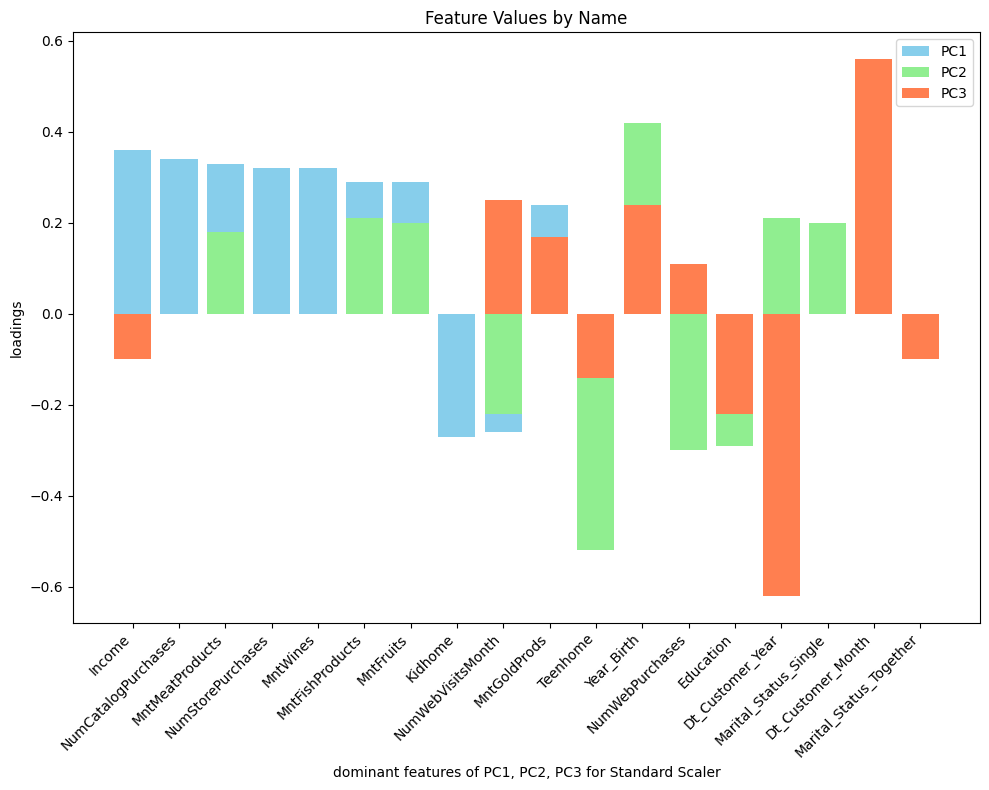

In [20]:
name1 = dominant_features_std.iloc[0,].str.extract(r'^(.*) \(')[0]
values1 = dominant_features_std.iloc[0,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name2 = dominant_features_std.iloc[1,].str.extract(r'^(.*) \(')[0]
values2 = dominant_features_std.iloc[1,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name3 = dominant_features_std.iloc[2,].str.extract(r'^(.*) \(')[0]
values3 = dominant_features_std.iloc[2,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)


plt.figure(figsize=(10, 8))
bars = plt.bar(name1, values1, color='skyblue', label="PC1") 
bars = plt.bar(name2, values2, color='lightgreen', label="PC2") 
bars = plt.bar(name3, values3, color='coral', label="PC3") 

plt.xlabel('dominant features of PC1, PC2, PC3 for Standard Scaler')
plt.ylabel('loadings')
plt.xticks(rotation=45, ha="right")
plt.title('Feature Values by Name')
plt.legend()
plt.tight_layout()



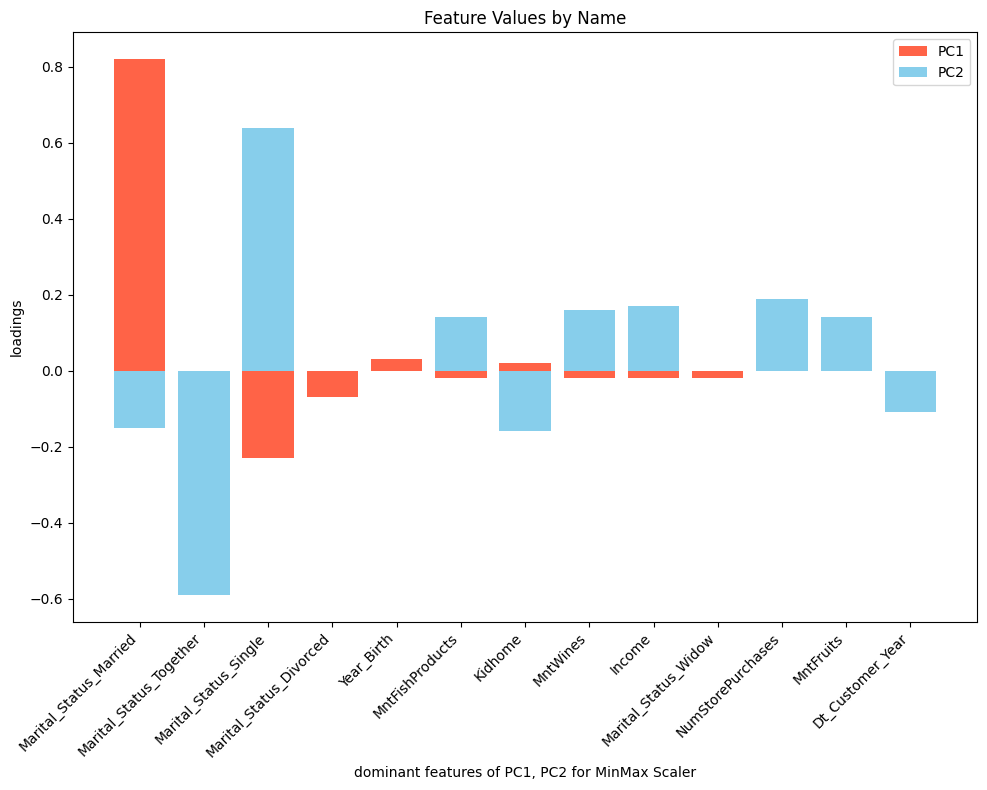

In [21]:
name1 = dominant_features_mm.iloc[0,].str.extract(r'^(.*) \(')[0]
values1 = dominant_features_mm.iloc[0,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name2 = dominant_features_mm.iloc[1,].str.extract(r'^(.*) \(')[0]
values2 = dominant_features_mm.iloc[1,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)


plt.figure(figsize=(10, 8))
bars = plt.bar(name1, values1, color='tomato', label="PC1") 
bars = plt.bar(name2, values2, color='skyblue', label="PC2") 


plt.xlabel('dominant features of PC1, PC2 for MinMax Scaler')
plt.ylabel('loadings')
plt.xticks(rotation=45, ha="right")
plt.title('Feature Values by Name')
plt.legend()
plt.tight_layout()

## Interpretation 
To be able to interpret the obtained principal components, we first need to find the high value positive and negative loadings of each principal component.
To find the high values loads of a principle component, we have to take the following steps: 
- After fitting the PCA model, access the components attribute of the model to get the loadings of the principal components. For example `pca.components_[0]` gives the loadings of the first principal component. What we get is an array of loadings for each column (Either positive or negative).
- Then for obtaining the high value loadings, considering the absolute value of the loadings, we sort the array of loadings in descending order and take the first $n$ elements where we consider $n = 10$ of the array. The indices of these elements are the indices of the columns that have the high value loadings for the corresponding principal component.

In [22]:
pd.set_option('display.max_colwidth',None)
summary_table_std

,Principal Component,Explained Variance,Dominant Features
0,PC1,22.83%,"[Income (0.36), NumCatalogPurchases (0.34), MntMeatProducts (0.33), NumStorePurchases (0.32), MntWines (0.32), MntFishProducts (0.29), MntFruits (0.29), Kidhome (-0.27), NumWebVisitsMonth (-0.26), MntGoldProds (0.24)]"
1,PC2,7.23%,"[Teenhome (-0.52), Year_Birth (0.42), NumWebPurchases (-0.30), Education (-0.29), NumWebVisitsMonth (-0.22), Dt_Customer_Year (0.21), MntFishProducts (0.21), MntFruits (0.20), Marital_Status_Single (0.20), MntMeatProducts (0.18)]"
2,PC3,6.93%,"[Dt_Customer_Year (-0.62), Dt_Customer_Month (0.56), NumWebVisitsMonth (0.25), Year_Birth (0.24), Education (-0.22), MntGoldProds (0.17), Teenhome (-0.14), NumWebPurchases (0.11), Income (-0.10), Marital_Status_Together (-0.10)]"


### Standard scaler naming:
- For **PC1**, the most important high values are `Income`, `NumCatalogPurchases`, `MntMeatProducts`. This PC seems to be capturing aspects related to customer affluence and purchasing behavior, particularly regarding higher-end shopping habits and a preference for meat products. A suitable name for this principal component could be **Affluent Consumer Behavior**
- For **PC2** important features are `Teenhome`, `Year_Birth`, `NumWebPurchases`. This PC appears to reflect generational purchasing trends, with a focus on the presence of teenagers at home (which is negatively correlated), the year of birth (which could indicate age, with a positive correlation), and the number of purchases made online (negatively correlated). Therefore, a fitting name could be: **Digital Generational Divide**
- **PC3** is characterized by features related to the timing of customer acquisition and online engagement. With `Dt_Customer_Year` having a negative correlation, and `Dt_Customer_Month` and `NumWebVisitsMonth` having positive correlations, the PC seems to encapsulate aspects of recent customer engagement and seasonality. A suitable name for this principal component could be: **Recent Engagement Seasonality**

In [23]:
summary_table_mm

,Principal Component,Explained Variance,Dominant Features
0,PC1,19.47%,"[Marital_Status_Married (0.82), Marital_Status_Together (-0.51), Marital_Status_Single (-0.23), Marital_Status_Divorced (-0.07), Year_Birth (0.03), MntFishProducts (-0.02), Kidhome (0.02), MntWines (-0.02), Income (-0.02), Marital_Status_Widow (-0.02)]"
1,PC2,13.23%,"[Marital_Status_Single (0.64), Marital_Status_Together (-0.59), NumStorePurchases (0.19), Income (0.17), Kidhome (-0.16), MntWines (0.16), Marital_Status_Married (-0.15), MntFishProducts (0.14), MntFruits (0.14), Dt_Customer_Year (-0.11)]"
2,PC3,13.19%,"[NumStorePurchases (0.39), Marital_Status_Single (-0.37), Kidhome (-0.37), MntWines (0.34), Income (0.34), MntFishProducts (0.25), MntFruits (0.24), Marital_Status_Together (0.23), MntMeatProducts (0.16), MntGoldProds (0.15)]"


### Min_Max scaler naming:
- **PC1** seems to be capturing aspects of marital status, distinguishing between different states of relationship commitment. With a strong positive correlation for `Marital_Status_Married`, a negative correlation for `Marital_Status_Together`, and considering `Marital_Status_Single` also plays a role (though its weight is not given), this PC could be named: **Marital Commitment Contrast**
- For **PC2**, Given the dominance of `Marital_Status_Single` with a positive correlation, `Marital_Status_Together` with a negative correlation, and `NumStorePurchases` indicating a level of retail engagement, this principal component focuses on the relationship status and its impact on shopping behavior. A suitable name could be: **Single Lifestyle Retail Activity**
-  For **PC3**, dominant features highlight a relationship between the number of store purchases, marital status, and the presence of children at home. With a positive correlation to `NumStorePurchases` and negative correlations to both `Marital_Status_Single` and `Kidhome`, it suggests a focus on the shopping behavior of possibly married or non-single individuals with fewer or no children at home. A fitting name for this principal component could be: **Family-Oriented Shopping Habit**

### Analyzing
The differences in the principal components (PCs) can be seen when using different standardization methods can be attributed to how these methods transform data, their formulas totally different which menthond below:
1. **Standard Scaling**: This scaling is not bounded, meaning the transformed values can have a wide range of values. $mean = 0$ and $std = 1$
$$
Z = \frac{(X - \mu)}{\sigma}
$$

2. **Min-Max Scaling**: This scaling compresses all inliers in the data into the range $[0, 1]$
$$
X_{\text{scaled}} = \frac{(X - X_{\text{min}})}{(X_{\text{max}} - X_{\text{min}})}
$$

The reason why the PCs are different with each standardization method lies in how the data is transformed:
- Standard Scaling sets center around $0$ with  variance $1$. It is more sensitive to variances in different directions in the dataset. If a feature varies widely (even if it's not in the range of the other features), it will influence the PCs.
- Maintains the original distribution of the feature but in a compressed range. It can be more influenced by the range of the features rather than their distribution around the mean.

The numbers associated with each feature in the output for dominant features, like $[NumCatalogPurchases (0.34), MntMeatProducts (0.34)]$, represent the loadings (or coefficients) of the features in the Principal Component (PC). 

In PCA, each original feature contributes to each principal component to a certain degree, which is quantified by these loadings. The loading of a feature in a principal component is a measure of:

1. **Magnitude (Value):** Indicates how strongly the feature influences the principal component. A higher absolute value of the loading means the feature has a stronger influence on the component.
   
2. **Direction (Sign):**
   - A **positive loading** (e.g., $0.34$) suggests that as the feature value increases, the principal component value also increases.
   - A **negative loading** (e.g., $-0.51$) implies that as the feature value increases, the principal component value decreases.

In our example:
- For the first PC, both `NumCatalogPurchases` and `MntMeatProducts` have loadings of approximately $0.34$. This means these features have a similar and positive influence on the first principal component. Their relatively high loading values indicate they are significant contributors to the variance this component captures.
  
- For the second PC, `Dt_Customer_Year` has a positive loading of $0.59$, and `Dt_Customer_Month` has a negative loading of $-0.51$. This means `Dt_Customer_Year` positively influences this component, while `Dt_Customer_Month` influences it in the opposite direction. The magnitude of these loadings suggests they are both important in defining the second principal component.

## PCA Score Plot
When choosing labels for coloring dots in PCA plots, typically we should select features that might explain some of the variance that principal components capture. In other words, we want to choose labels that might have a meaningful relationship with the patterns you're observing in PCA scatter plots.

1. **For PCs: 'Affluent Consumer Behavior', 'Digital Generational Divide', 'Recent Engagement Seasonality' (Standardized Data):**
   - **'Response'**: This label, which indicates whether a customer responded to the last campaign, can provide insights into how different consumer segments (affluent consumers, generational divides in digital behavior, and seasonal engagement patterns) are influenced by marketing efforts. Coloring by Response could reveal patterns of campaign effectiveness across these behavioral and demographic divides.

2. **For PCs: 'Marital Commitment Contrast', 'Single Lifestyle Retail Activity', 'Family-Oriented Shopping Habits' (Min-Max Normalized Data):**
   - **NumDealsPurchases**:This label represents the number of purchases made with a discount and could relate closely to the shopping habits influenced by marital status and family orientation. It might reveal how single vs. non-single (married or living together) individuals, and those with family-oriented shopping habits, differ in their propensity to take advantage of deals, possibly due to differing budgetary constraints or shopping priorities.

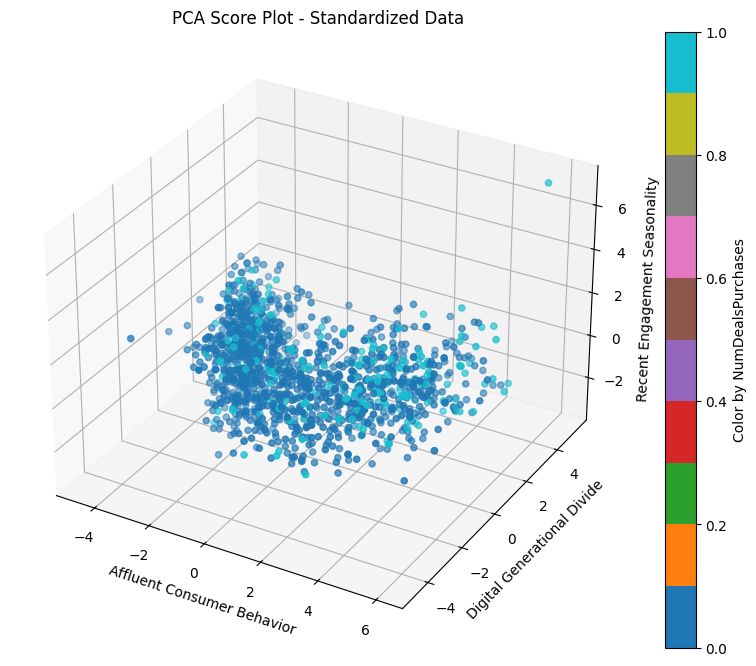

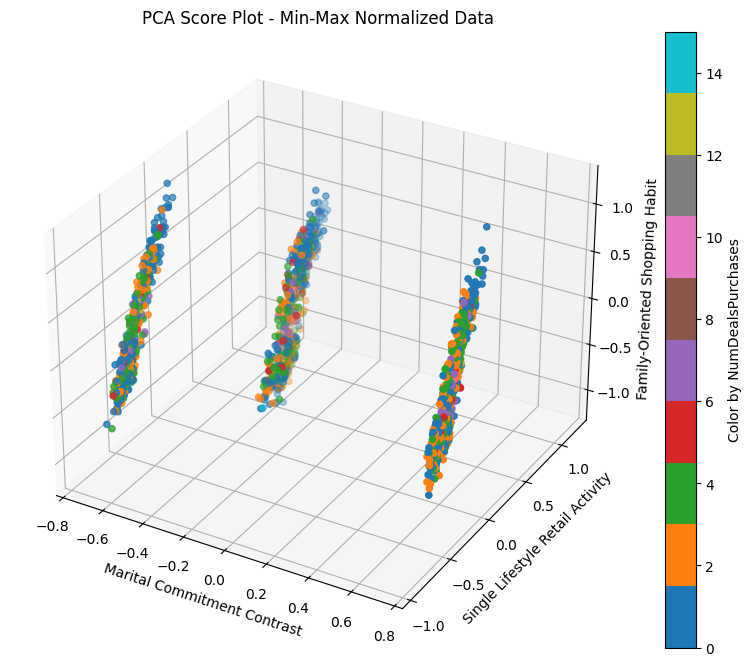

In [24]:
def plot_pca_scores(pca_scores, labels, pc_names, title):
    if len(pc_names) == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=labels, alpha=0.7,   
                              linewidth=0.5, cmap='tab10')
    
        plt.xlabel(pc_names[0])
        plt.ylabel(pc_names[1])
        plt.title(title)
        plt.colorbar(scatter, label='Color by Label')
        plt.grid(True)
        plt.show()
    elif len(pc_names) == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_scores[:, 0], pca_scores[:, 1], pca_scores[:, 2], c=labels, cmap='tab10')
        
        ax.set_xlabel(pc_names[0])
        ax.set_ylabel(pc_names[1])
        ax.set_zlabel(pc_names[2])
        ax.set_title(title)
        fig.colorbar(scatter, ax=ax, label='Color by NumDealsPurchases')
        plt.show()
        


plot_pca_scores(X_std_pca,labels= workdf['Response'], pc_names = ['Affluent Consumer Behavior', 'Digital Generational Divide', 'Recent Engagement Seasonality'],
                title='PCA Score Plot - Standardized Data')
plot_pca_scores(X_mm_pca,labels= workdf['NumDealsPurchases'], pc_names = ['Marital Commitment Contrast', ' Single Lifestyle Retail Activity','Family-Oriented Shopping Habit'],
                  title='PCA Score Plot - Min-Max Normalized Data')

# Exercise 5 (k-Means)
The term "with respect to the 'PC-space'" refers to performing in the space defined by the Principal Components (PCs) rather than in the original feature space. 

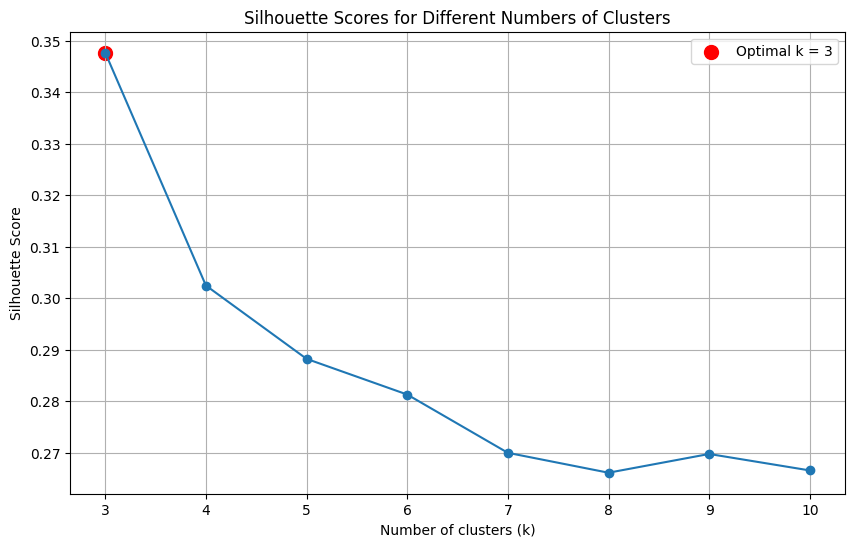

For Standardized Data optimal k is: 3 with Silhouette Score: 0.3477


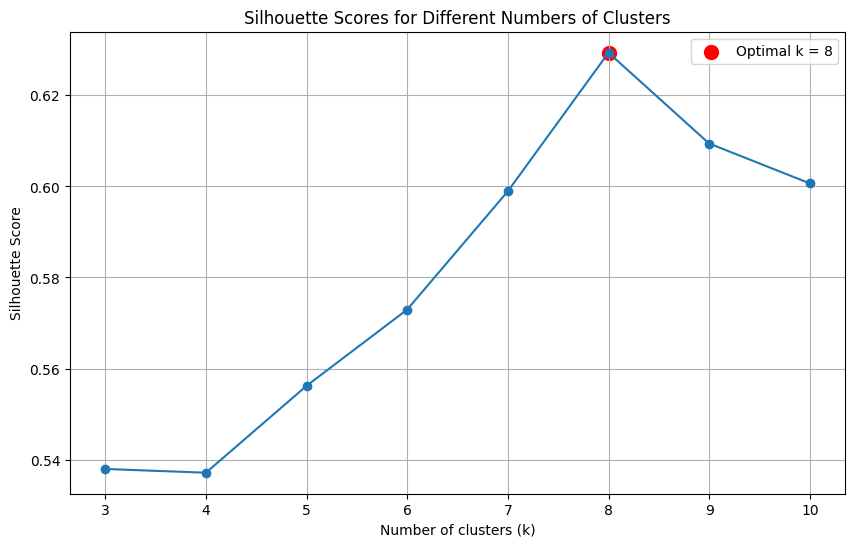

For Min-Max Normalized Data optimal k is: 8 with Silhouette Score: 0.6294


In [25]:
def optimal_k_using_silhouette(pca_data, k_range=range(3, 11)):
    """
    Find the optimal number of clusters (k) using the silhouette coefficient and plot the scores.
    :param pca_data: Data transformed into PCA space
    :param k_range: Range of k values to test
    :return: Optimal k value and silhouette score for optimal k
    """
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_data)
        silhouette_avg = silhouette_score(pca_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Determine the optimal number of clusters
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.scatter(optimal_k, optimal_score, color='red', s=100, label=f'Optimal k = {optimal_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_k, optimal_score


# Example usage with your PCA-transformed data
std_optimal_k, std_silhouette_score = optimal_k_using_silhouette(X_std_pca)
print(f"For Standardized Data optimal k is: {std_optimal_k} with Silhouette Score: {std_silhouette_score:.4f}")

mm_optimal_k, mm_silhouette_score = optimal_k_using_silhouette(X_mm_pca)
print(f"For Min-Max Normalized Data optimal k is: {mm_optimal_k} with Silhouette Score: {mm_silhouette_score:.4f}")



# Exercise 6 (Clusters and Centroid Interpretation and Visualization)

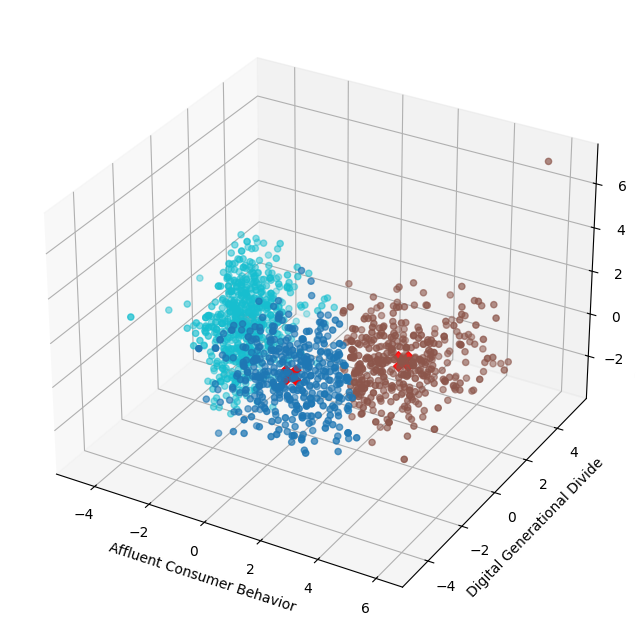

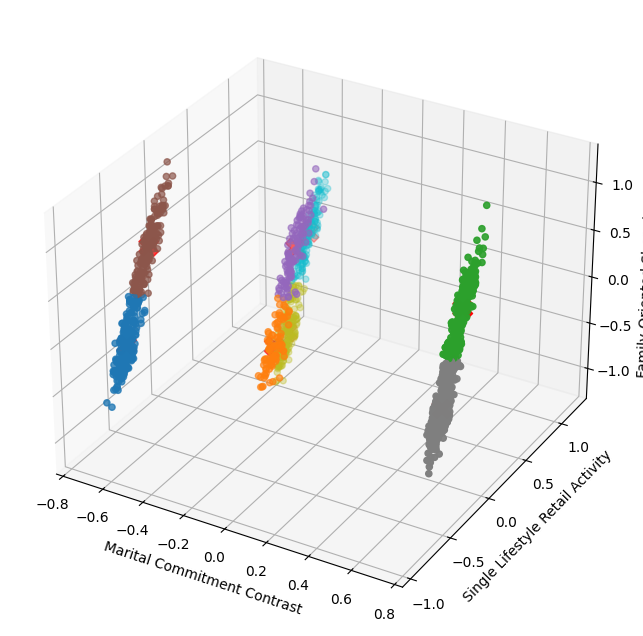

In [26]:
def plot_clusters_and_centroids(pca_scores, kmeans, pc_names, title):
    # Extract the cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    # Plotting
    if len(pc_names) == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=labels, alpha=0.7, cmap='viridis')
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='r')  # Centroids in red
        plt.xlabel(pc_names[0])
        plt.ylabel(pc_names[1])
    elif len(pc_names) == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_scores[:, 0], pca_scores[:, 1], pca_scores[:, 2], c=labels, cmap='tab10')
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=200, c='r')  # Centroids in red
        ax.set_xlabel(pc_names[0])
        ax.set_ylabel(pc_names[1])
        ax.set_zlabel(pc_names[2])


kmeans_std = KMeans(n_clusters=std_optimal_k, random_state=rs, n_init=10).fit(X_std_pca)

kmeans_mm = KMeans(n_clusters=mm_optimal_k, random_state=rs, n_init=10).fit(X_mm_pca)

plot_clusters_and_centroids(X_std_pca, kmeans_std,['Affluent Consumer Behavior', 'Digital Generational Divide', 'Recent Engagement Seasonality'], "Standardized Data")

plot_clusters_and_centroids(X_mm_pca, kmeans_mm,  ['Marital Commitment Contrast', ' Single Lifestyle Retail Activity','Family-Oriented Shopping Habit'],"Min-Max Normalized Data")


## Describing the Centroids

### Standardized Data Centroids

In [27]:
num_pcs = summary_table_std.shape[0]
num_centroids = len(kmeans_std.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_std.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_std['Explained Variance'][pc_index]
        dominant_features = summary_table_std['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features[:3]}")
    print("-------------------------")


Centroid 1:
	PC1(0.4800)
		 Explained Variance: 22.83%
		 Dominant Features: ['Income (0.36)', 'NumCatalogPurchases (0.34)', 'MntMeatProducts (0.33)']
	PC2(-1.3685)
		 Explained Variance: 7.23%
		 Dominant Features: ['Teenhome (-0.52)', 'Year_Birth (0.42)', 'NumWebPurchases (-0.30)']
	PC3(-0.1105)
		 Explained Variance: 6.93%
		 Dominant Features: ['Dt_Customer_Year (-0.62)', 'Dt_Customer_Month (0.56)', 'NumWebVisitsMonth (0.25)']
-------------------------
Centroid 2:
	PC1(3.1876)
		 Explained Variance: 22.83%
		 Dominant Features: ['Income (0.36)', 'NumCatalogPurchases (0.34)', 'MntMeatProducts (0.33)']
	PC2(0.7517)
		 Explained Variance: 7.23%
		 Dominant Features: ['Teenhome (-0.52)', 'Year_Birth (0.42)', 'NumWebPurchases (-0.30)']
	PC3(0.0460)
		 Explained Variance: 6.93%
		 Dominant Features: ['Dt_Customer_Year (-0.62)', 'Dt_Customer_Month (0.56)', 'NumWebVisitsMonth (0.25)']
-------------------------
Centroid 3:
	PC1(-2.2746)
		 Explained Variance: 22.83%
		 Dominant Features: ['

#### Interpretation
- Centroid 1: "*Young, Digital Natives*"<br>
**Characteristics**: This cluster represents customers with moderate income levels and a balanced mix of catalog and meat product purchases. Their negative score in PC2 suggests a younger demographic (higher Year_Birth value) that may not engage as much in web purchases, possibly preferring other digital channels or in-store experiences. The negative scores in PC3 indicate recent engagement with the company, potentially new customers with a higher frequency of web visits.<br>
**Summary**: Customers in this cluster are likely younger, recently engaged with the brand, and show a diverse purchasing behavior including both digital and physical store interactions.

- Centroid 2: "*Affluent, Established Shoppers*"<br>
**Characteristics**: With a high positive score in PC1, this group likely has higher income and engages significantly in catalog purchases, indicating a preference for premium products, especially meats. The positive score in PC2 with a slight emphasis on older demographics suggests these customers are more established, possibly with families. The near-neutral score in PC3 suggests steady engagement over time without significant recent spikes in activity.<br>
**Summary**: This cluster characterizes affluent, possibly older customers with stable purchasing patterns, favoring catalog shopping and quality products.

- Centroid 3: "*Budget-Conscious, Varied Age Group*"
**Characteristics**: A negative score in PC1 indicates lower income levels or more conservative spending habits, particularly in catalog and meat product purchases. The positive score in PC2 suggests a mix of younger and older demographics, potentially families, reflected by the less negative impact of Teenhome and a balanced approach to web purchases. The neutral score in PC3 suggests a consistent level of web engagement, indicating familiarity with digital platforms.<br>
**Summary**: This cluster seems to represent customers with more budget-conscious spending habits, spanning a broad age range, and showing consistent digital engagement.

## Min-Max Normalized Data Centroids

In [28]:
num_pcs = summary_table_mm.shape[0]
num_centroids = len(kmeans_mm.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_mm.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_mm['Explained Variance'][pc_index]
        dominant_features = summary_table_mm['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features[:3]}")
    print("-------------------------")

Centroid 1:
	PC1(-0.6404)
		 Explained Variance: 19.47%
		 Dominant Features: ['Marital_Status_Married (0.82)', 'Marital_Status_Together (-0.51)', 'Marital_Status_Single (-0.23)']
	PC2(-0.6912)
		 Explained Variance: 13.23%
		 Dominant Features: ['Marital_Status_Single (0.64)', 'Marital_Status_Together (-0.59)', 'NumStorePurchases (0.19)']
	PC3(-0.1390)
		 Explained Variance: 13.19%
		 Dominant Features: ['NumStorePurchases (0.39)', 'Marital_Status_Single (-0.37)', 'Kidhome (-0.37)']
-------------------------
Centroid 2:
	PC1(-0.1853)
		 Explained Variance: 19.47%
		 Dominant Features: ['Marital_Status_Married (0.82)', 'Marital_Status_Together (-0.51)', 'Marital_Status_Single (-0.23)']
	PC2(-0.0436)
		 Explained Variance: 13.23%
		 Dominant Features: ['Marital_Status_Single (0.64)', 'Marital_Status_Together (-0.59)', 'NumStorePurchases (0.19)']
	PC3(-0.3485)
		 Explained Variance: 13.19%
		 Dominant Features: ['NumStorePurchases (0.39)', 'Marital_Status_Single (-0.37)', 'Kidhome (-0.37

#### Interpretation:

- Centroid 1: "*Newlyweds or Committed Partners*"<br>
**Characteristics**: This cluster leans towards married status with a negative inclination towards being single or living together, suggesting these are either newly married couples or those in committed partnerships. Their lower engagement in store purchases could indicate a preference for online shopping or a conservative spending pattern.

- Centroid 2: "*Established Married Couples*"<br>
**Characteristics**: With a slight negative score on PC1 and nearly neutral on PC2 and PC3, this group likely represents established married couples who have a balanced lifestyle, engaging moderately in store purchases, and have a stable family structure without the extremes of being newly married or having a home full of kids.

- Centroid 3: "*Affluent and Active Families*"<br>
**Characteristics**: Positive scores in PC1 and PC3 suggest these are affluent married individuals possibly with children, actively making store purchases. Their lifestyle could be centered around family activities, including shopping as a family event.

- Centroid 4: "*Single and Active Shoppers*"<br>
**Characteristics**: This group, with a slight positive on PC2 and PC3, could be characterized by single individuals who are active in-store shoppers. They may enjoy a lifestyle that allows for spontaneous and frequent shopping trips, possibly due to having no children at home.

- Centroid 5: "*Solo Parents or Singles*"<br>
**Characteristics**: Negative scores on PC1 and PC2 but a high positive on PC3 suggest this cluster may include single parents or singles who are very active in-store shoppers. The presence of children at home does not deter their shopping frequency.

- Centroid 6: "*Marital Bliss Shoppers*"<br>
**Characteristics**: The highest scores in PC1 among the centroids, this cluster represents individuals in a blissful marital state, possibly without the complexities of child-rearing, reflected in their balanced store purchase behavior.

- Centroid 7: "*Dynamic Singles*"<br>
**Characteristics**: With a high score on PC2, this cluster is likely dominated by dynamic singles who are very active in-store purchasers. Their lifestyle could be marked by a high degree of personal freedom and social activities.

- Centroid 8: "*Socially Active Singles or Couples*"<br>
**Characteristics**: The highest score on PC2 among all centroids suggests these are either socially active singles or couples without children, deeply engaged in in-store purchasing, reflecting a lifestyle of social outings that include shopping.

# Exercise 7 (Clusters and Centroids Evaluation)

## Internal Evaluation - Silhouette Scores

In [29]:
silhouette_std = silhouette_score(X_std_pca, kmeans_std.labels_)
silhouette_mm = silhouette_score(X_mm_pca, kmeans_mm.labels_)

print(f"Silhouette Score for Standardized Data: {silhouette_std:.4f}")
print(f"Silhouette Score for Min-Max Normalized Data: {silhouette_mm:.4f}")


Silhouette Score for Standardized Data: 0.3477
Silhouette Score for Min-Max Normalized Data: 0.6294


## Checking the distribution of labels in dataset:

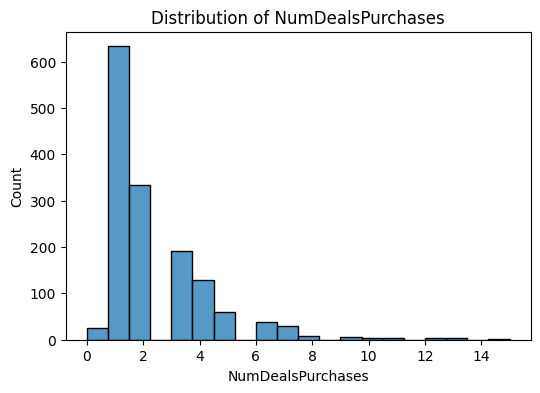

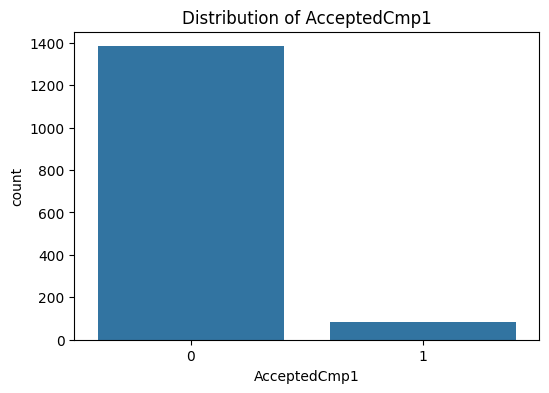

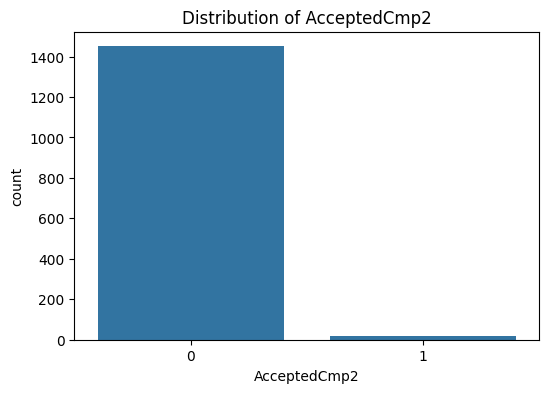

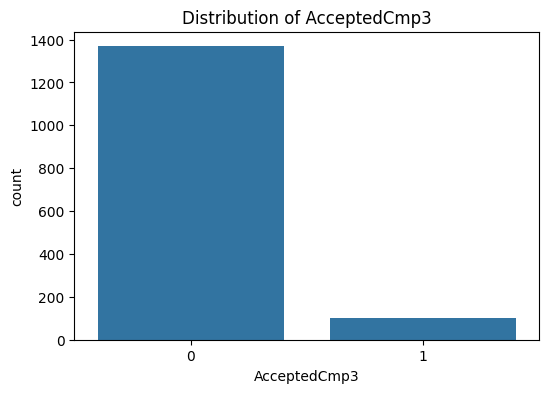

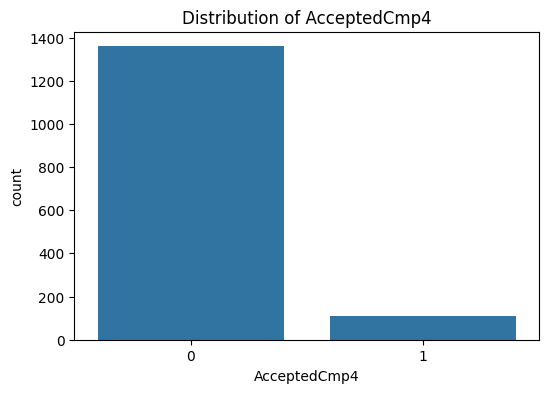

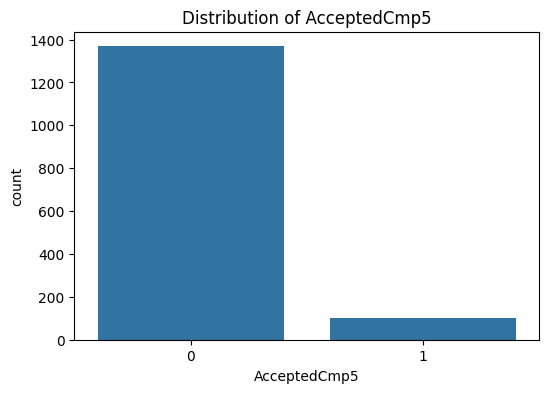

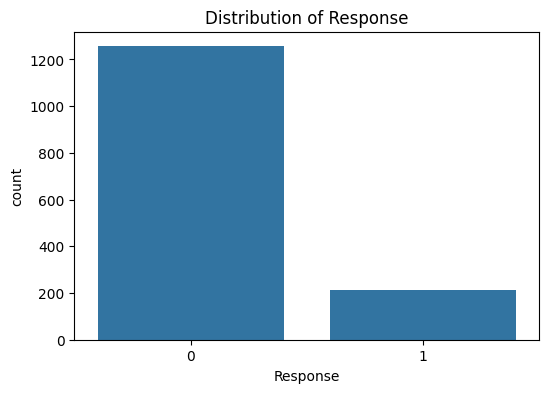

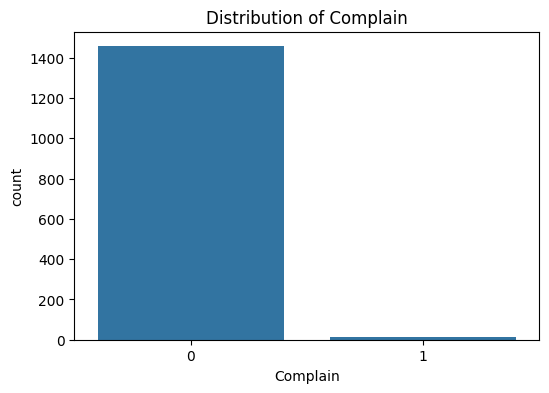

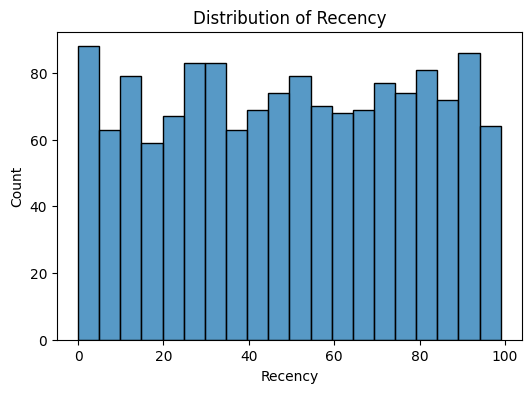

In [30]:
for label in labels:
    plt.figure(figsize=(6, 4))
    if workdf[label].nunique() <= 2:  # For binary labels
        sns.countplot(x=label, data=workdf)
    else:  # For continuous labels
        sns.histplot(workdf[label], bins=20, kde=False)
    plt.title(f'Distribution of {label}')
    plt.show()

Among the shown histograms for each label, the distribution of the **Recency** label appears to be quite uniform, suggesting that customers' last purchase is fairly evenly spread out over the time frame considered. It can be a meaningful label for external evaluation for several reasons:
-  Customer Engagement: 'Recency' can indicate how recently customers have engaged with the company, which is a key metric in customer relationship management. Recent interactions might suggest more active or engaged customers.

-  Segmentation Relevance: Clusters may differentiate between recent and less recent customers. This can be valuable for targeted marketing campaigns.

-  Behavioral Insight: The behavior of customers with different 'Recency' values within the same cluster may offer insights into the cluster's characteristics.

## External Evaluation

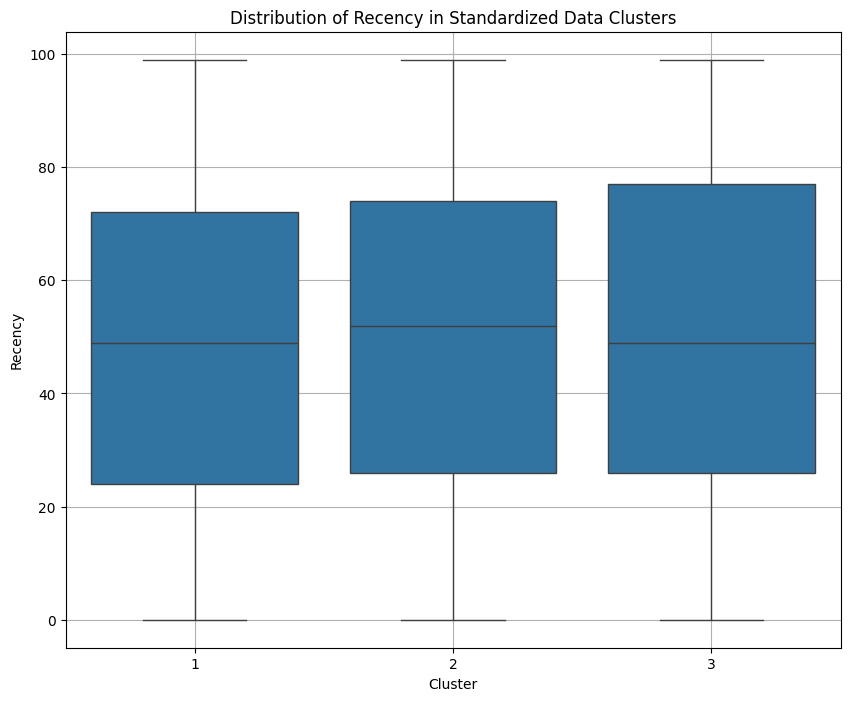

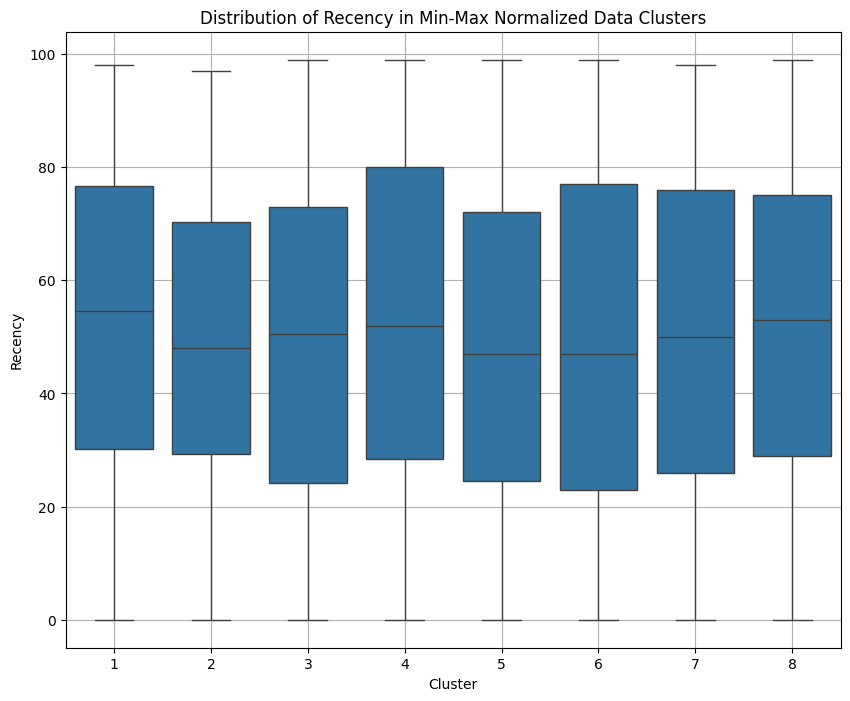

In [31]:
def plot_external_label_distribution(original_df, kmeans_model, label_column, title=''):
    """
    Plot the distribution of a specified label within each cluster.
    :param original_df: Original DataFrame with label_column
    :param kmeans_model: Trained KMeans model
    :param label_column: The name of the column to use for external evaluation
    """
    # Add the cluster assignments to the original DataFrame
    df_with_clusters = original_df.copy()
    df_with_clusters['Cluster'] = kmeans_model.labels_+1

    # Plot
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='Cluster', y=label_column, data=df_with_clusters)
    plt.title(f"Distribution of {label_column} in {title} Clusters")
    plt.xlabel('Cluster')
    plt.ylabel(label_column)
    plt.grid()
    plt.show()


plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_std, label_column='Recency',
                                 title="Standardized Data")
plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_mm, label_column='Recency',
                                 title="Min-Max Normalized Data")


## Results Comparison


From the **Standardized Data** boxplot, we observe the following:
- There are three clusters.
- The median 'Recency' values across the three clusters do not vary significantly, which suggests that the clusters might not be distinctly separated based on the 'Recency' feature alone.
- The interquartile range (IQR) is quite similar across the clusters, indicating similar variation in 'Recency' within each cluster.
- There are no extreme outliers, which implies that standardization has normalized the 'Recency' values well across all clusters.

From the **Min-Max Normalized Data** boxplot, we observe:
- There are eight clusters, indicating a finer segmentation of the data.
- The median 'Recency' values vary slightly more across clusters compared to the standardized data, but there's still a significant overlap, which suggests that 'Recency' may not be the primary feature driving the segmentation.
- The IQRs show variability in 'Recency' across clusters, but like the standardized data, the variation within each cluster is relatively consistent.
- Similar to the standardized data, there are no extreme outliers, which is a characteristic of min-max normalization that keeps all values within a bounded range.

**Comparative Analysis**:
- The increased number of clusters in the min-max normalized data could suggest over-segmentation or a more sensitive clustering process, potentially due to the effect of normalization.
- The consistency in median 'Recency' across different numbers of clusters implies that 'Recency' behaves similarly in both normalized datasets. This might indicate that 'Recency' is not the defining feature of customer segmentation in this context, or that customers have a broad but consistent range of recency across segments.
- The lack of outliers in both suggests that extreme values of 'Recency' do not heavily influence the cluster formation.